In [1]:
%matplotlib inline

## Load packages
import os
import pickle
import datetime
import numpy as np
import pandas as pd
from numba import jit

from scipy import stats
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf, pacf, ARMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab
import seaborn as sns

# CCIWR class project
This code implements monte carlo simulation and prediction based on autoregressive processes.

In [2]:
# Some plotting defaults
sns.set(style="ticks")
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams["figure.figsize"] = [12, 8]

<bound method NDFrame.tail of tstamp
1931-01-01     704.800000
1931-02-01     442.200000
1931-03-01     698.900000
1931-04-01    1423.000000
1931-05-01    1049.000000
                 ...     
1997-08-01     662.100000
1997-09-01     670.210973
1997-10-01     601.300000
1997-11-01     476.900000
1997-12-01     304.300000
Name: discharge_cmps, Length: 804, dtype: float64>

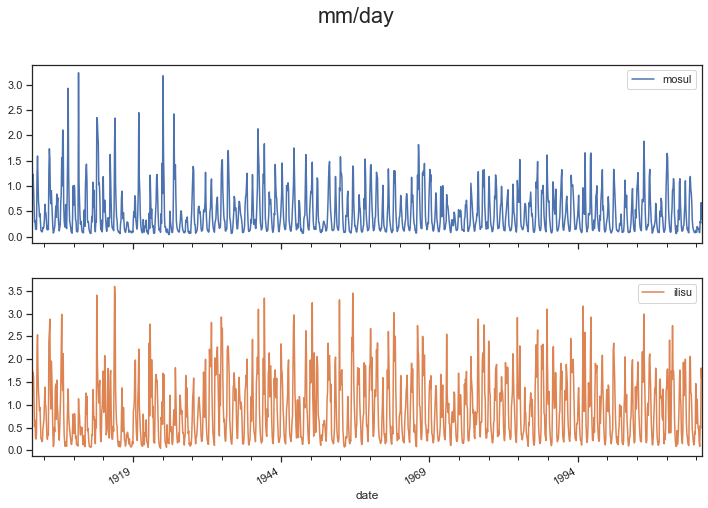

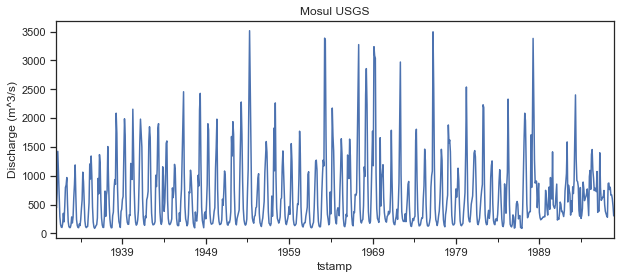

In [102]:
# Load the data
df = pd.read_csv("data/GRUN/grun_data.csv", index_col='date', usecols=['date', 'mosul', 'ilisu'], parse_dates=True)
df.plot(subplots=True, title='mm/day')

# usgs data
mosul_usgs = pd.read_csv("data/USGS/MosulMonthly1931-1997.csv", sep=';', index_col = 'year')
mosul_usgs = mosul_usgs.unstack().reset_index()
mosul_usgs = mosul_usgs.rename(columns={"level_0": "month", 0: 'discharge_cmps'})
mosul_usgs['day'] = np.repeat(1, len(mosul_usgs))
mosul_usgs['tstamp'] = pd.to_datetime(mosul_usgs[['day', 'month', 'year']], format="%d%m%Y")
mosul_usgs = mosul_usgs.sort_values(by='tstamp').set_index('tstamp')['discharge_cmps']
mosul_usgs = mosul_usgs.fillna(value=mosul_usgs.mean())

f, ax = plt.subplots()
ax = mosul_usgs.plot(title="Mosul USGS", figsize=(10,4))
ax.set_ylabel('Discharge (m^3/s)')
mosul_usgs.tail

In [4]:
df.mosul.corr(mosul_usgs)

0.501333200777497

Convert mm/day to m^3/s
https://www.researchgate.net/post/How_to_convert_discharge_m3_s_to_mm_of_discharge

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11fc06250>,
      dtype=object)

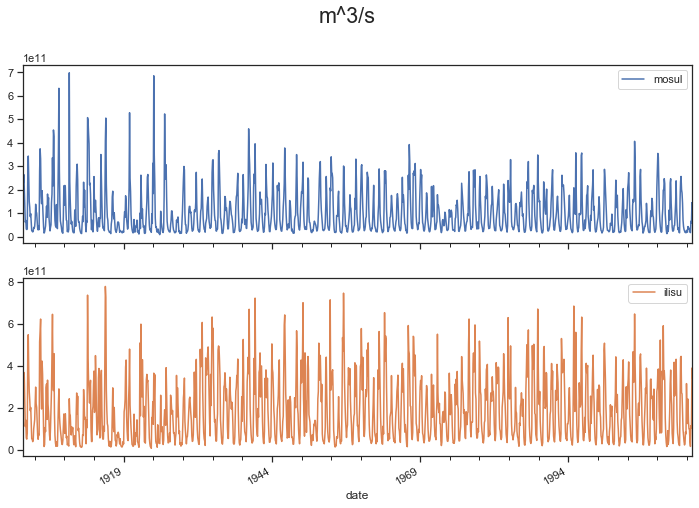

In [5]:
# approximate pixel area in m^2
pixel_area = 50000*50000
day2seconds = 24*60*60

# mm/day --> m/day
m_per_day = df / 1000

# m/day --> m^3/day
cubicmeters_per_day = m_per_day * pixel_area

# m^3/day --> m^3/second
cubicmeters_per_second = cubicmeters_per_day * day2seconds
cubicmeters_per_second.plot(subplots=True, title='m^3/s')

Find order of auto-regressive process (monthly sampling): AR(1) seems likely

Text(0.5, 0.98, 'Mosul USGS')

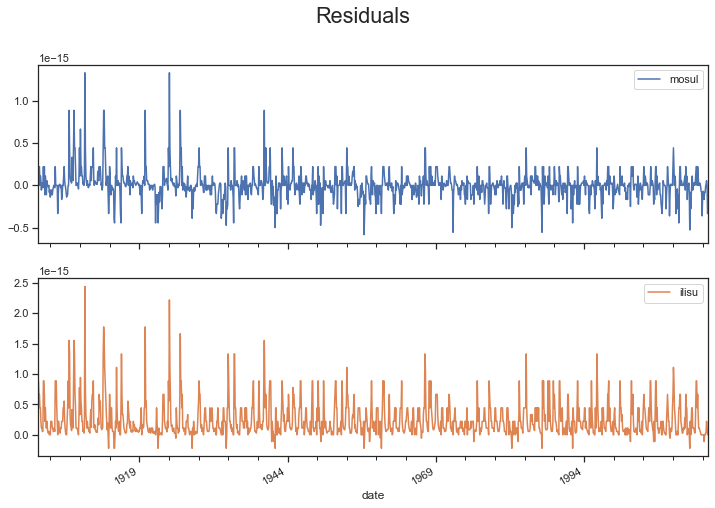

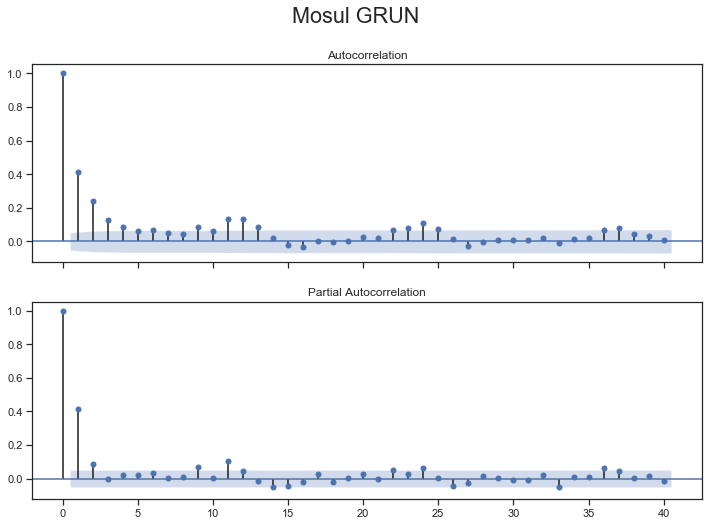

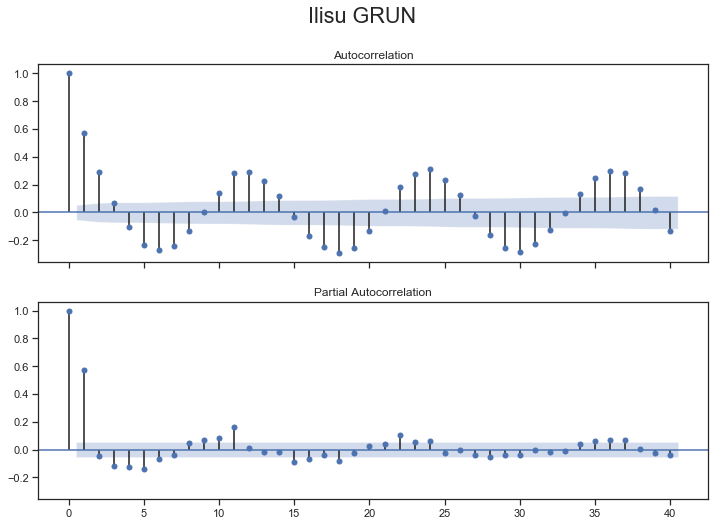

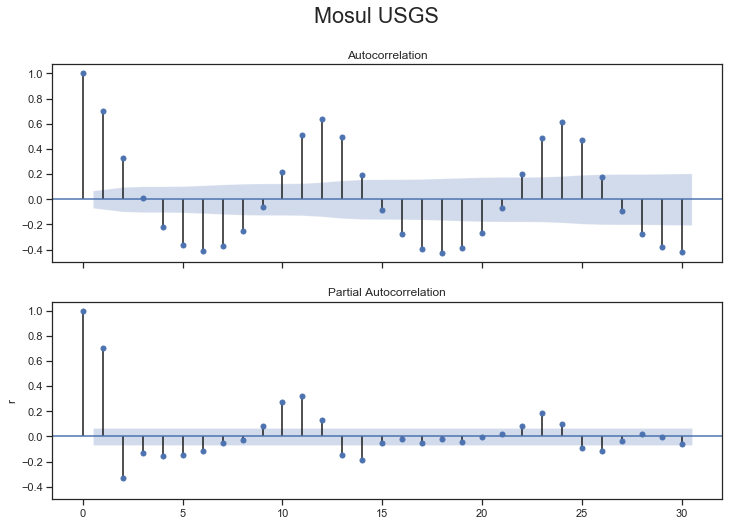

In [34]:
def detrend(s):
    y = s.values
    x = list(range(1, len(s) + 1))
    x = np.reshape(x, (-1, 1))
    x = sm.add_constant(x)  # to add intercept"
    trd = sm.OLS(y, x).fit()  # fit regression"
    trend = trd.predict(x)  # compute trend line"
    return pd.Series(data=(y-trend), index=s.index)

# detrend
df_residuals = df.apply(detrend, axis=1)
df_residuals.plot(subplots=True, title="Residuals")

# acf and pacf
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
x = sm.graphics.tsa.plot_acf(df_residuals.mosul.values.squeeze(), lags=40, ax=axes[0])
y = sm.graphics.tsa.plot_pacf(df_residuals.mosul.values.squeeze(), lags=40, ax=axes[1])
plt.suptitle("Mosul GRUN")


fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
x = sm.graphics.tsa.plot_acf(df_residuals.ilisu.values.squeeze(), lags=40, ax=axes[0])
y = sm.graphics.tsa.plot_pacf(df_residuals.ilisu.values.squeeze(), lags=40, ax=axes[1])
plt.suptitle("Ilisu GRUN")

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
x = sm.graphics.tsa.plot_acf(mosul_usgs.values.squeeze(), lags=30, ax=axes[0])
y = sm.graphics.tsa.plot_pacf(mosul_usgs.values.squeeze(), lags=30, ax=axes[1])
plt.ylabel('r')
plt.suptitle("Mosul USGS")

An auto-regressive model of order 1 ("AR(1)" process) is described by

$X_t = c + \phi * X_{t-1} + \epsilon_t$.

It specifies that the output variable depends linearly on its own previous 
values lagged by $t$ and on a stochastic term $\epsilon_t$ in the form of a 
stochastic difference equation.
In the regression analysis above we made the iid assumptions. Since the data 
seem to follow an AR(1) process, the assumption of independence between 
residuals $\epsilon_t$ is flawed. This leads to a biased trend estimate. 

We need these 3 formulas:

1) $x_t = \beta_0 + \beta_1 * t + \epsilon_t$

2) $\epsilon_{t} = \epsilon_{t-1} * \alpha + w_t$

3) Combined: $x_t = \beta_0 + \beta_1 * t + x_{t-1} * \alpha + w_t$

In [7]:
class TimeSeriesModel(object):
    def __init__(self, ts):
        assert type(ts) is pd.Series, "Class expects a pd.Series as input."
        self.ts = ts
        self.freq = self.ts.index.freq
        self.y = ts.values
        self.idx = ts.index.values # store datetime index
        self.slen = ts.shape[0] # length of SI data
        self.x = np.arange(1, self.slen + 1, 1) # discrete vector
        
        # fix as column vectors
        self.x.shape = (self.slen, 1)
        self.y.shape = (self.slen, 1)
        
        # set seed
        np.random.seed(42)

    def fit(self, ar_order=1, ar_trend='n'):
        """fit the 4 model parameters"""
        # OLS
        self.ar_order = ar_order
        self.ar_trend = ar_trend
        xvec = np.reshape(self.x, (-1, 1))
        xvec = sm.add_constant(xvec)  # to add intercept
        ols = sm.OLS(self.y, xvec).fit()  # fit regression
        self.beta0 = ols.params[0] # OLS intercept
        self.beta1 = ols.params[1] # OLS slope
        self.trend_line = ols.predict(xvec) # trend line
        self.trend_line.shape = (self.slen, 1)
        self.residuals = self.y - self.trend_line # residuals
        
        # AR
        AR = AutoReg(endog=self.residuals, lags=self.ar_order, trend=self.ar_trend) # fit AR process
        ARfit = AR.fit(cov_type="HC0") # robust SE
        html = ARfit.summary().as_html() # save model results
        self.sd = float(pd.read_html(html)[0].iloc[2,3]) # get sd
        self.alpha = float(pd.read_html(html)[1].iloc[1,1]) # get autocorrelation
        return self

    def monte_carlo(self, n=1):
        """Do n simulations."""
        self.out_shape = (self.slen, n)

        # trend matrix
        trend_mat = np.tile(self.trend_line, (1, n))

        # white noise matrix
        white_noise = np.random.normal(0, self.sd, size=self.out_shape)

        # red noise matrix: fill iteratively
        red_noise = np.empty_like(white_noise)
        for pos in np.arange(1, self.slen):
            red_noise[pos,:] = self.alpha * red_noise[pos-1,:] + white_noise[pos,:]
        
        # compute sum
        xt = trend_mat + red_noise
        
        # to dataframe
        self.simulation = pd.DataFrame(data=xt, index=self.idx, columns=np.arange(1, xt.shape[1] + 1))
        return self
    
    def plot(self, what='obs'):
        """Plot obs, sim or extrp"""
        if what not in ['obs', 'sim', 'extrp']:
            raise IOError("Data does not exist.")
        
        if what == 'obs':
            data = self.ts
        elif what == 'sim':
            data = self.simulation
        else:
            data = self.extrapolation
        
        # compute statistics
        if data.shape[1] > 1:
            self.quantiles = data.quantile(q=[0, 0.025, 0.25, 0.5, 0.75, 0.975, 1], axis=1).transpose()

            # plot simulation results
            # ------------------------------
            f, ax = plt.subplots(figsize=(10,5))
            # median
            self.quantiles[0.5].plot(ax=ax, color='blue', alpha=0.3)
            
            # observations
            ts_obs = pd.Series(data=np.ravel(self.y), index=self.idx)
            ts_obs.name = 'obs'
            ts_obs.plot(ax=ax, color='red', alpha=0.5)
            
            # min - max
            ax.fill_between(self.quantiles.index.values,
                            self.quantiles[0],
                            self.quantiles[1],
                            color='black', alpha=0.1)
            
            # 2.5% - 97.5%
            ax.fill_between(self.quantiles.index.values,
                            self.quantiles[0.025],
                            self.quantiles[0.975],
                            color='black', alpha=0.2)
            
            # 25% - 75%
            ax.fill_between(self.quantiles.index.values,
                            self.quantiles[0.25],
                            self.quantiles[0.75],
                            color='black', alpha=0.3)
            
            ax.set_ylabel("Discharge (mm/day)")
        
        else:
            f, ax = plt.subplots(figsize=(10,5))
            data.plot(ax=ax, color='blue', alpha=0.3)
            #self.ts.plot(ax=ax, color='red', alpha=0.3)
            ax.set_ylabel("Discharge (mm/day)")
        
        plt.legend()
        return f, ax
    
            
    def extrapolate(self, until, n=1):
        """Extrapolate time series into the future based on the fitted AR model."""
        
        # construct index
        last_obs = self.ts.index[-1]
        first_extrp = last_obs + relativedelta(months=1)
        new_idx = pd.date_range(first_extrp, until, freq='M')
        combined_idx = pd.date_range(self.ts.index[0], until, freq='M')
        
        # extrapolate trend
        new_len = len(new_idx) + self.slen
        new_x = np.arange(1, new_len + 1)[self.slen:]
        trd_extrp = self.beta0 + self.beta1 * new_x
        trd_extrp.shape = (len(trd_extrp), 1)
        self.slen_extrp = len(new_idx)
        out_shape_extrp = (self.slen_extrp, n)
        
        # simulate AR process
        trend_mat = np.tile(trd_extrp, (1, n))
        
        # extrapolate stochastic components
        white_noise = np.random.normal(0, self.sd, size=out_shape_extrp)

        # create (1, n) array of the last observations residual
        resid_last_obs = self.residuals[0][0]
        last_obs_array = np.repeat(resid_last_obs, n)
        
        # create empty red noise matrix
        red_noise = np.empty_like(white_noise)
        
        # initialise AR process with the last observation
        red_noise = np.vstack((last_obs_array, red_noise))
        
        # red noise matrix: fill iteratively
        for pos in np.arange(1, self.slen_extrp):
            red_noise[pos,:] = self.alpha * red_noise[pos-1,:] + white_noise[pos,:]
        
        # compute sum
        xt = trend_mat + red_noise[1:,]
        
        
        # combine with observations
        observations = np.tile(self.y, (1, n))
        combined_series = np.concatenate((observations, xt), axis=0)
        
        # to series
        self.extrapolation = pd.DataFrame(data=combined_series, 
                                          index=combined_idx, 
                                          columns=np.arange(1, combined_series.shape[1] + 1))
        return self    

## Monte Carlo Simulation for Ilisu

In [8]:
# run simulation            
n_realisations = 100
model_ilisu = TimeSeriesModel(ts=df.ilisu)
model_ilisu = model_ilisu.fit(ar_order=1)
model_ilisu = model_ilisu.monte_carlo(n=n_realisations)

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b16a150>)

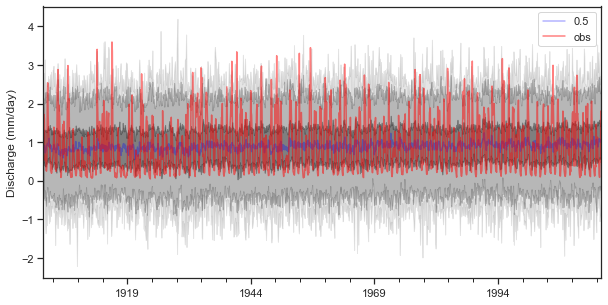

In [9]:
model_ilisu.plot(what='sim')

extrapolate to ~ 2030. TODO: figure out where exactly to initialise the AR process (last obs, right?)

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b54fc50>)

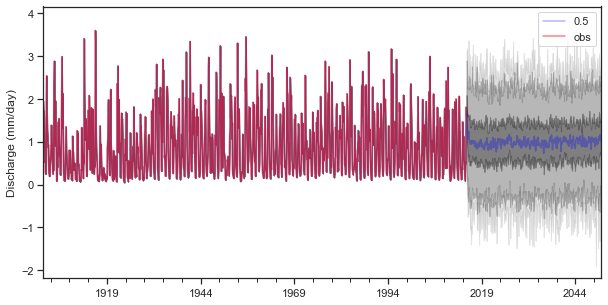

In [10]:
model_ilisu = model_ilisu.extrapolate(until='2050-12-31', n=n_realisations)
model_ilisu.plot(what='extrp')

## Monte Carlo Simulation for Mosul

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11d64e390>)

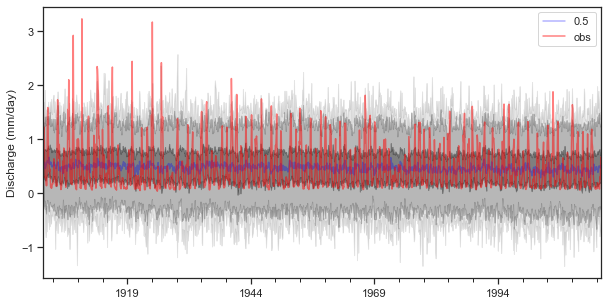

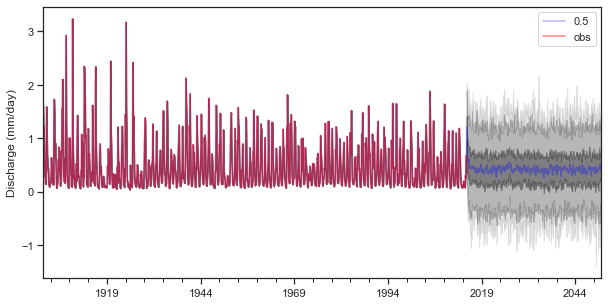

In [11]:
# run simulation            
model_mosul = TimeSeriesModel(ts=df.mosul)
model_mosul = model_mosul.fit()
model_mosul = model_mosul.monte_carlo(n=n_realisations)

# plot simulations
model_mosul.plot(what='sim')

# extrapolate
model_mosul = model_mosul.extrapolate(until='2050-12-31', n=n_realisations)
model_mosul.plot(what='extrp')

Calculate quantiles of the simulation distributions

# Monte carlo simulation for Mosul using USGS data

0.11546249324677546

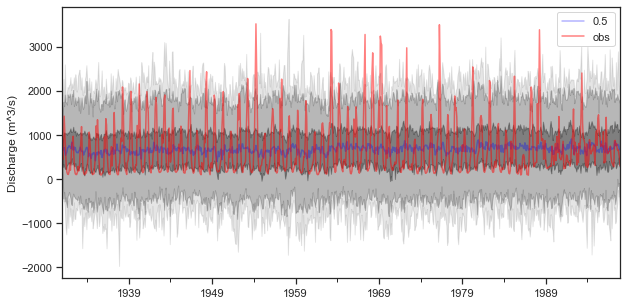

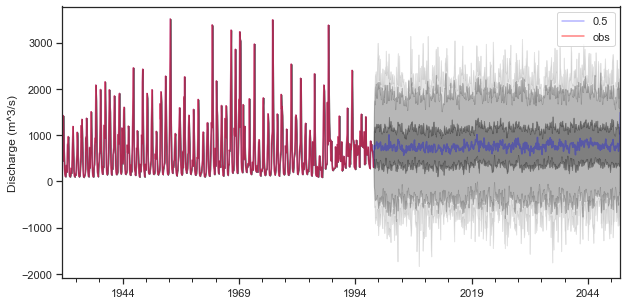

In [101]:
model_mosul_usgs = TimeSeriesModel(ts=mosul_usgs)
model_mosul_usgs = model_mosul_usgs.fit(ar_order=1)
model_mosul_usgs = model_mosul_usgs.monte_carlo(n=100)

# plot historical simulation
f, ax = model_mosul_usgs.plot(what='sim')
ax.set_ylabel("Discharge (m^3/s)")

# extrapolate
model_mosul_usgs = model_mosul_usgs.extrapolate(until='2050-12-31', n=n_realisations)
f, ax2 = model_mosul_usgs.plot(what='extrp')
ax2.set_ylabel("Discharge (m^3/s)")

# linear trend (m^3/s)
model_mosul_usgs.beta1

Store 100 simulations each

In [13]:
model_ilisu.extrapolation.to_csv("data/monte_carlo/extrapolation_ilisu.csv")
model_mosul.extrapolation.to_csv("data/monte_carlo/extrapolation_mosul.csv")
model_mosul_usgs.extrapolation.to_csv("data/monte_carlo/extrapolation_mosul_usgs.csv")

model_ilisu.simulation.to_csv("data/monte_carlo/simulation_ilisu.csv")
model_mosul.simulation.to_csv("data/monte_carlo/simulation_mosul.csv")
model_mosul_usgs.simulation.to_csv("data/monte_carlo/simulation_mosul_usgs.csv")

seasonality of Mosul USGS data: take simulation data for the start and extrapolation data for the end

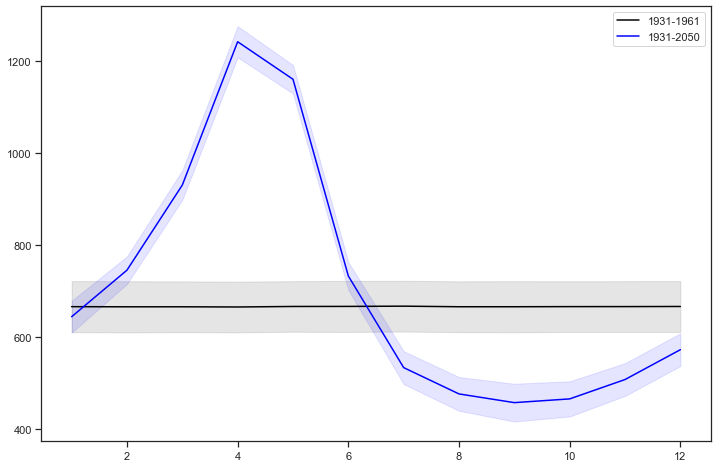

In [100]:
usgs_start = model_mosul_usgs.simulation.loc['1931-01-31':'1991-12-31']
usgs_end = model_mosul_usgs.extrapolation.loc['2020-01-31':'2050-12-31']

# start
usgs_start_mean = usgs_start.groupby(usgs_start.index.month).mean()
usgs_start_mean = usgs_start_mean.mean(axis=1)
usgs_start_sd = usgs_start.groupby(usgs_start.index.month).std()
usgs_start_sd = usgs_start_sd.std(axis=1)

# end
usgs_end_mean = usgs_end.groupby(usgs_end.index.month).mean()
usgs_end_mean = usgs_end_mean.mean(axis=1)
usgs_end_sd = usgs_end.groupby(usgs_end.index.month).std()
usgs_end_sd = usgs_end_sd.std(axis=1)

# all years
usgs_all_mean = model_mosul_usgs.extrapolation.groupby(model_mosul_usgs.extrapolation.index.month).mean()
usgs_all_mean = usgs_all_mean.mean(axis=1)
usgs_all_sd = model_mosul_usgs.extrapolation.groupby(model_mosul_usgs.extrapolation.index.month).std()
usgs_all_sd = usgs_all_sd.std(axis=1)

# figure
fig, ax = plt.subplots()


# historical simulation
"""
usgs_start_mean.name = "1931-1961"
usgs_start_mean.plot(ax=ax, legend=False, color='black')
ax.fill_between(usgs_start_mean.index.values,
                usgs_start_mean.values - usgs_start_sd.values,
                usgs_start_mean.values + usgs_start_sd.values,
                color='black', alpha=0.1)
"""

# future extrapolation
#usgs_end_mean.plot(ax=ax, legend=False, color='red')
#ax.fill_between(usgs_end_mean.index.values,
#                usgs_end_mean.values - usgs_end_sd.values,
#                usgs_end_mean.values + usgs_end_sd.values,
#               color='red', alpha=0.1)

# all years
usgs_all_mean.name = "1931-2050"
usgs_all_mean.plot(ax=ax, color='blue', legend=False)
ax.fill_between(usgs_all_mean.index.values,
                usgs_all_mean.values - usgs_all_sd.values,
                usgs_all_mean.values + usgs_all_sd.values,
                color='blue', alpha=0.1)

plt.legend()

In [14]:
quantiles = [0., 0.025, 0.25, 0.5, 0.75, 0.975, 1.]
quantiles_ilisu = model_ilisu.extrapolation.quantile(q=quantiles, axis=1).T
quantiles_mosul = model_mosul.extrapolation.quantile(q=quantiles, axis=1).T
quantiles_mosul_usgs = model_mosul_usgs.extrapolation.quantile(q=quantiles, axis=1).T

Negative discharge doesn't make a whole lot of sense. Set values < 0 to 0.

In [15]:
quantiles_ilisu = quantiles_ilisu.where(quantiles_ilisu > 0., 0.)
quantiles_mosul = quantiles_mosul.where(quantiles_mosul > 0., 0.)
quantiles_mosul_usgs = quantiles_mosul_usgs.where(quantiles_mosul_usgs > 0., 0.)

Text(0, 0.5, 'Discharge (m^3/s)')

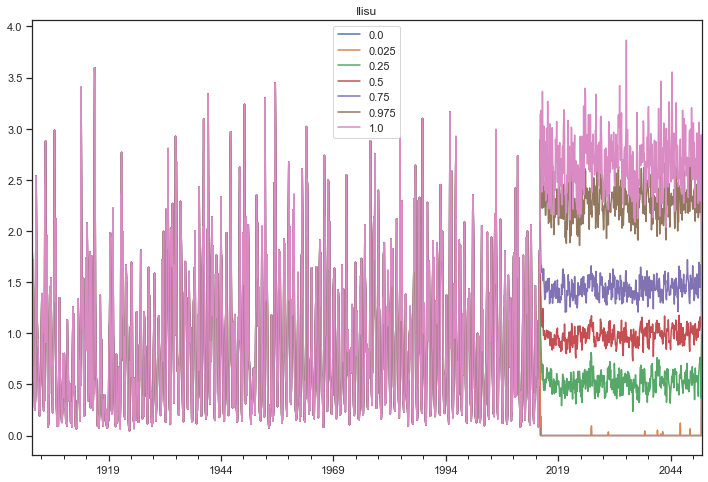

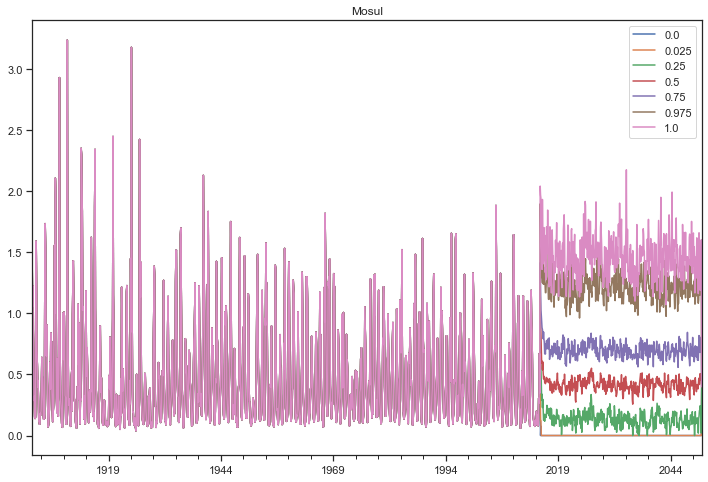

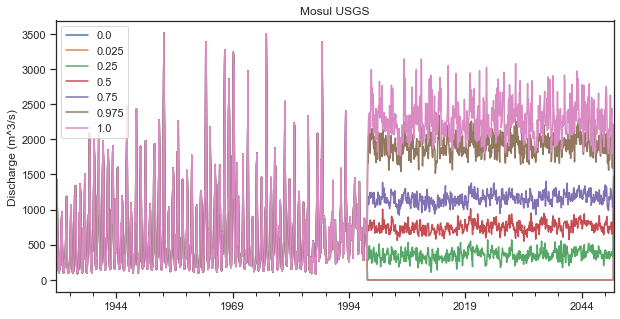

In [35]:
quantiles_ilisu.plot(title="Ilisu")
quantiles_mosul.plot(title="Mosul")
ax = quantiles_mosul_usgs.plot(title="Mosul USGS", figsize=(10,5))
ax.legend(loc='upper left')
ax.set_ylabel("Discharge (m^3/s)")

In [17]:
quantiles_ilisu.to_csv("data/monte_carlo/quantiles_ilisu.csv")
quantiles_mosul.to_csv("data/monte_carlo/quantiles_mosul.csv")
quantiles_mosul_usgs.to_csv("data/monte_carlo/quantiles_mosul_usgs.csv")

In [18]:
usgs_data = pd.read_csv("data/usgs/MosulMean1931-1997.csv")
usgs_mosul = usgs_data['MeanDis'][:-1]
usgs_mosul

0      553.93
1      739.28
2     1076.22
3     1629.11
4     1478.86
5      717.72
6      364.34
7      265.16
8      217.93
9      241.40
10     318.32
11     431.77
Name: MeanDis, dtype: float64

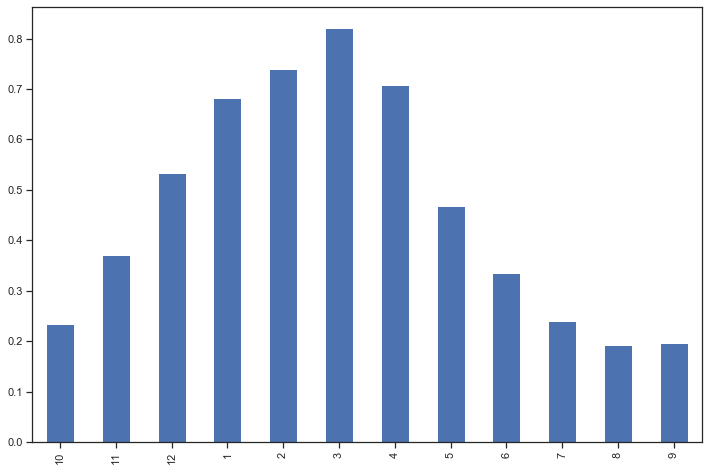

In [19]:
fig, ax = plt.subplots()

climatology_mosul = model_mosul.extrapolation.groupby(model_mosul.extrapolation.index.month).mean()
climatology_mosul.name = "Mosul"
climatology_mosul = climatology_mosul.mean(axis=1)

climatology_mosul_usgs = model_mosul_usgs.extrapolation.groupby(model_mosul_usgs.extrapolation.index.month).mean()
climatology_mosul_usgs.name = "Mosul USGS"
climatology_mosul_usgs = climatology_mosul_usgs.mean(axis=1)

x = np.roll(climatology_mosul.index.values, 3)
y = np.roll(climatology_mosul.values, 3)

mosul_reordered = pd.Series(index=x, data=y)
mosul_reordered.plot.bar()


#climatology_ilisu = extrapolation_ilisu.groupby(extrapolation_mosul.index.month).mean()
#climatology_ilisu.name = "Ilisu"
#climatology_ilisu.mean(axis=1).plot(ax=ax)


we see the impact of the trend in the extrapolations on the runoff regime, as it shifts towards winter

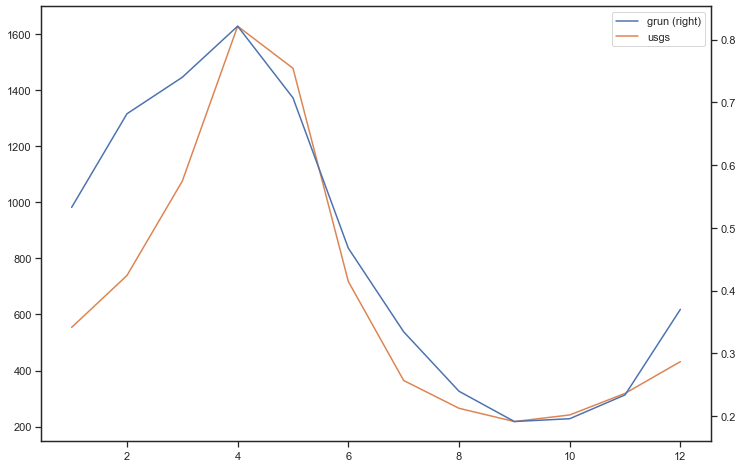

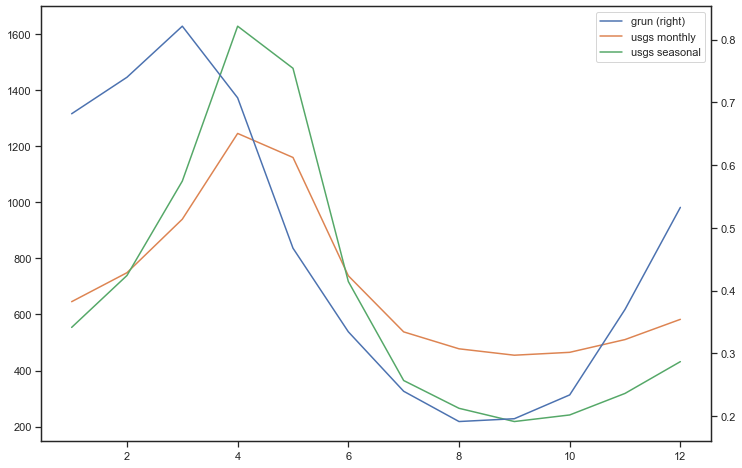

In [20]:
climatology_mosul.values
usgs_mosul.values
index = np.arange(1, len(usgs_mosul.values) + 1)

# 1 month rolled
merged = pd.DataFrame(index=index,
            data={'grun': np.roll(climatology_mosul.values, 1),
                  'usgs': pd.to_numeric(usgs_mosul.values)})

merged.plot(secondary_y='grun')

# original
merged = pd.DataFrame(index=index,
            data={'grun': climatology_mosul.values,
                  'usgs monthly': climatology_mosul_usgs.values,
                  'usgs seasonal': pd.to_numeric(usgs_mosul.values)})

merged.plot(secondary_y='grun')